In [0]:
import os, re, io
import pandas as pd
import numpy as np
import requests

## stopwords
from gensim.parsing.preprocessing import remove_stopwords
## lemma functionality provide by NLTK
from nltk.stem import WordNetLemmatizer
## make sure you downloaded model for lemmatization
#nltk.download('wordnet')
from nltk import word_tokenize
## make sure you downloaded model for tokenization
#nltk.download('punkt')
import spacy
nlp = spacy.load('en')

## TF_IDF for BOW
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
## cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
## mount google drive
from google.colab import drive
drive.mount('/content/gdrive')
INPUT_DIR = r'gdrive/My Drive/colab data/COVID_FAQ_QA'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Collection Process

It is very important process in Data Science. We should collect the data from various places and combine them for our analysis. 

In this notebook, I will be using COVID-19 FAQ questions from available online resources.
  1. https://www.un.org/sites/un2.un.org/files/new_dhmosh_covid-19_faq.pdf
  2. https://www.mohfw.gov.in/pdf/FAQ.pdf

In this part, Will be using FAQ questions from Point 2 website for our entire QA similarity task.

#### Download dataset from source

The COVID-19 FAQ data available in online. We will be taking one of the resources available in [online]( https://www.un.org/sites/un2.un.org/files/new_dhmosh_covid-19_faq.pdf) for our FAQ question answering mechanism.


In [0]:
## The data is taken from https://www.un.org/sites/un2.un.org/files/new_dhmosh_covid-19_faq.pdf
## it has FAQ based question and answering for COVID-19

def download_pdf_url(dataset_url, file_name):
  response = requests.get(dataset_url)
  pdf_content_output = None
  with io.BytesIO(response.content) as open_pdf_file:
      with open(file_name,'w') as obj:
        obj.write(str(open_pdf_file))    


In [0]:
dataset_url = 'https://www.un.org/sites/un2.un.org/files/new_dhmosh_covid-19_faq.pdf'
## download pdf from URL and save the pdf file
download_pdf_url(dataset_url, 'new_dhmosh_covid-19_faq.pdf')

#### Convert Structured output (.csv) from Unstructured document (.pdf)

Our downloaded FAQ dataset is PDF file. We should always gather relevant information into structured format from the unstructured document. It is very important step in our flow. We will be following below steps,

1.   Convert PDF into Text file
2.   Formulate Question and answers from the text
3.   Store as CSV file

In this article, I used [pdftools - R module](https://github.com/ropensci/pdftools) for converting PDF to TXT file which is not covered in the below code. 



In [0]:
## QA will be stored as .csv file
def extract_QA_from_text_file(INPUT_DIR, text_file_name):
  output_file_name = 'covid_19faq.csv'
  with open(os.path.join(INPUT_DIR, text_file_name), 'r', encoding='latin') as obj:
      text = obj.read()

  text = text.strip()
  ## extract the question by following pattern
  pattern = '\n+\s*\d+[.](.*?)\?'
  question_pattern = re.compile(pattern,re.MULTILINE|re.IGNORECASE|re.DOTALL)  
  matched_QA_positions = [(m.start(0),m.end(0)) for m in question_pattern.finditer(text)]
  print(f"Available no of question is {len(matched_QA_positions)}")
  ## store question and answer pair
  questions = {}
  ## iterate every matched QA 
  for index in range(len(matched_QA_positions)):
      ## get the start and end position
      faq_start_pos = matched_QA_positions[index][0]
      faq_end_pos = matched_QA_positions[index][1]
      
      if index == len(matched_QA_positions) - 1:
          next_faq_start_pos = -1
      else:
          next_faq_start_pos = matched_QA_positions[index+1][0]

      ## get the question from start and end position from original text      
      question = text[faq_start_pos:faq_end_pos]
      if next_faq_start_pos == -1:
          answer = text[faq_end_pos:]
      else:
          answer = text[faq_end_pos:next_faq_start_pos]
      ## replace multiple new lines to space in questions and answers
      question = re.sub("\n+"," ",question.strip())
      answer = re.sub("\n+"," ",answer.strip())
      questions[question] = answer
      
  ## create dataframe from key-value pair
  faq_df = pd.DataFrame.from_dict(questions, orient='index', columns=["answers"])
  faq_df["questions"] = faq_df.index
  faq_df.reset_index(inplace=True)  
  faq_df[["questions", "answers"]].to_csv(os.path.join(INPUT_DIR, output_file_name),index = False)
  print(f"COVID QA file {output_file_name} created")

In [11]:
## Converted PDF to .txt file using pdftools in R and stored in my google drive
## create a question-answer pair in csv
extract_QA_from_text_file(INPUT_DIR, 'new_dhmosh_covid-19_faq.txt')

Available no of question is 39
COVID QA file covid_19faq.csv created


We've created CSV file, which contains 39 different FAQ questions about COVID-19.

#### Take a look at COVID QA Data

In [12]:
QA_df = pd.read_csv(os.path.join(INPUT_DIR, "covid_19faq.csv"))
print("Dimension of dataset ",QA_df.shape)
print("Available columns ",QA_df.columns)

Dimension of dataset  (39, 2)
Available columns  Index(['questions', 'answers'], dtype='object')


In [13]:
## Take a look at first 10rows
QA_df.head(10)

,questions,answers
0,1. How does COVID-19 spread?,People can catch COVID-19 from others who have...
1,2. What are the symptoms of COVID-19?,The most common symptoms of COVID-19 are fever...
2,3. How do I know if it is COVID-19 or just the...,A COVID-19 infection has the same signs and sy...
3,4. Can the virus that causes COVID-19 be trans...,Studies to date suggest that the virus that ca...
4,5. What can I do to protect myself and prevent...,Protection measures for everyone Stay aware ...
5,6. I am well and asymptomatic. Should I use a ...,"According to the WHO, for individuals without ..."
6,7. How likely am I to catch COVID-19?,The risk depends on where you are - and more s...
7,8. Are pregnant women more susceptible to the ...,We do not have information from published scie...
8,9. What is the risk of my child becoming sick ...,"Based on available evidence, children do not a..."
9,10. Are the symptoms of COVID-19 different in ...,No. The symptoms of COVID-19 are similar in ch...


## Preprocessing Techniques

Next step, We will not use the data as it is. Preprocessing is another very important step to fine-tune the dataset.

1.   Remove unwanted characters
2.   Remove Question number
3.   Remove stopwords
4.   Lemmatization - to reduce inflection of words and minimize the word ambiguity. 

**Why I chosen lemmatization over stemming?**
Lemmatization is powerful operation as it takes into consideration of morphological analysis of the word. Example: bicycles or bicycles are converted to bicyles.
But, stemming algorithm works by predefined rules to remove prefix or suffix of the word.


In [0]:
## Data Preprocessing
class TextPreprocessor():
  def __init__(self, data_df, column_name=None):
    self.data_df = data_df  
    if not column_name and type(colum_name) == str:
      raise Exception("column name is mandatory. Make sure type is string format")
    self.column = column_name
    self.convert_lowercase()    
    self.applied_stopword = False
    self.processed_column_name = f"processed_{self.column}"
  def convert_lowercase(self):
    ## fill empty values into empty
    self.data_df.fillna('',inplace=True)
    ## reduce all the columns to lowercase
    self.data_df = self.data_df.apply(lambda column: column.astype(str).str.lower(), axis=0)    

  def remove_question_no(self):
    ## remove question no        
    self.data_df[self.column] = self.data_df[self.column].apply(lambda row: re.sub(r'^\d+[.]',' ', row))    
      
  def remove_symbols(self):
    ## remove unwanted character          
    self.data_df[self.column] = self.data_df[self.column].apply(lambda row: re.sub(r'[^A-Za-z0-9\s]', ' ', row))    

  def remove_stopwords(self):
    ## remove stopwords and create a new column 
    for idx, question in enumerate(self.data_df[self.column]):      
      self.data_df.loc[idx, self.processed_column_name] = remove_stopwords(question)        

  def apply_lemmatization(self, perform_stopword):
    ## get the root words to reduce inflection of words 
    lemmatizer = WordNetLemmatizer()    
    ## get the column name to perform lemma operation whether stopwords removed text or not
    if perform_stopword:
      column_name = self.processed_column_name
    else:
      column_name = self.column
    ## iterate every question, perform tokenize and lemma
    for idx, question in enumerate(self.data_df[column_name]):
      
      lemmatized_sentence = []
      ## use spacy for lemmatization
      doc = nlp(question.strip())
      for word in doc:       
        lemmatized_sentence.append(word.lemma_)      
      ## update to the same column
      self.data_df.loc[idx, self.processed_column_name] = " ".join(lemmatized_sentence)

  def process(self, perform_stopword = True):
    self.remove_question_no()
    self.remove_symbols()
    if perform_stopword:
      self.remove_stopwords()
    self.apply_lemmatization(perform_stopword)    
    return self.data_df

In [15]:
## pre-process training question data
text_preprocessor = TextPreprocessor(QA_df.copy(), column_name="questions")
processed_QA_df = text_preprocessor.process(perform_stopword=True)
print(processed_QA_df.head(10))

                                           questions  ...                                processed_questions
0                          how does covid 19 spread   ...                                    covid 19 spread
1                 what are the symptoms of covid 19   ...                                   symptom covid 19
2    how do i know if it is covid 19 or just the ...  ...                           know covid 19 common flu
3    can the virus that causes covid 19 be transm...  ...                  virus cause covid 19 transmit air
4    what can i do to protect myself and prevent ...  ...                     protect prevent spread disease
5    i am well and asymptomatic  should i use a m...  ...                              asymptomatic use mask
6                 how likely am i to catch covid 19   ...                              likely catch covid 19
7    are pregnant women more susceptible to the c...  ...  pregnant woman susceptible covid 19 virus harm...
8    what is the ri

## TF_IDF Representation

In [0]:
class TF_IDF():
  def __init__(self):
    self.dictionary = None    
    self.model = None
    self.bow_corpus = None

  def create_tf_idf_model(self, data_df, column_name):
    ## create sentence token list
    sentence_token_list = [sentence.split(" ") for sentence in data_df[column_name]]
    
    ## dataset vocabulary
    self.dictionary = Dictionary(sentence_token_list) 

    ## bow representation of dataset
    self.bow_corpus = [self.dictionary.doc2bow(sentence_tokens) for sentence_tokens in sentence_token_list]

    ## compute TF-IDF score for corpus
    self.model = TfidfModel(self.bow_corpus)

    ## representation of question and respective TF-IDF value
    print(f"First 10 question representation of TF-IDF vector")
    for index, sentence in enumerate(data_df[column_name]):
      if index <= 10:
        print(f"{sentence} {self.model[self.bow_corpus[index]]}")
      else:
        break

  def get_vector_for_test_set(self, test_df, column_name):
    ## store tf-idf vector
    testset_tf_idf_vector = []
    sentence_token_list = [sentence.split(" ") for sentence in test_df[column_name]]
    test_bow_corpus = [self.dictionary.doc2bow(sentence_tokens) for sentence_tokens in sentence_token_list]   
    for test_sentence in test_bow_corpus:
      testset_tf_idf_vector.append(self.model[test_sentence])      
    
    return testset_tf_idf_vector

  def get_training_QA_vectors(self):
    QA_vectors = []
    for sentence_vector in self.bow_corpus:
      QA_vectors.append(self.model[sentence_vector])      
    return QA_vectors
  
  def get_train_vocabulary(self):
    vocab = []
    for index in self.dictionary:
      vocab.append(self.dictionary[index])
    return vocab

In [0]:
## helps to retrieve similar question based of input vectors/embeddings for test query
def retrieveSimilarFAQ(train_question_vectors, test_question_vectors, train_QA_df, train_column_name, test_QA_df, test_column_name):
  similar_question_index = []
  for test_index, test_vector in enumerate(test_question_vectors):
    sim, sim_Q_index = -1, -1
    for train_index, train_vector in enumerate(train_question_vectors):
      sim_score = cosine_similarity(train_vector, test_vector)[0][0]
     
      if sim < sim_score:
        sim = sim_score
        sim_Q_index = train_index
    
    print("######")
    print(f"Query Question: {test_QA_df[test_column_name].iloc[test_index]}")    
    print(f"Retrieved Question: {train_QA_df[train_column_name].iloc[sim_Q_index]}")
    print("######")    

In [37]:
tf_idf = TF_IDF()
tf_idf.create_tf_idf_model(processed_QA_df, "processed_questions")
## get the tf-idf reprentation 
question_QA_vectors = tf_idf.get_training_QA_vectors()

First 10 question representation of TF-IDF vector
covid 19 spread [(0, 0.1464585856867653), (1, 0.1464585856867653), (2, 0.9783147578143063)]
symptom covid 19 [(0, 0.20700051037748057), (1, 0.20700051037748057), (3, 0.9561911824561682)]
know covid 19 common flu [(0, 0.07405033838335093), (1, 0.07405033838335093), (4, 0.49464180281321546), (5, 0.6100666281974102), (6, 0.6100666281974102)]
virus cause covid 19 transmit air [(0, 0.06637843630899026), (1, 0.06637843630899026), (7, 0.5468613609083381), (8, 0.5468613609083381), (9, 0.5468613609083381), (10, 0.30661989860866423)]
protect prevent spread disease [(2, 0.48411630600355454), (11, 0.5970850032877234), (12, 0.41803385433699597), (13, 0.48411630600355454)]
asymptomatic use mask [(14, 0.633702064906015), (15, 0.44367035721096526), (16, 0.633702064906015)]
likely catch covid 19 [(0, 0.0934565878402429), (1, 0.0934565878402429), (17, 0.6242717603092403), (18, 0.7699457783889204)]
pregnant woman susceptible covid 19 virus harm fetus [(0,

In [0]:
document_vocabulary = tf_idf.get_train_vocabulary()

#### Evaulaute TF-IDF representation for QA similarity

In [39]:
test_query_string = ["how does covid-19 spread?", 
                     "What are the symptoms of COVID-19?",
                "Should I wear a mask to protect myself from covid-19",              
                "Is there a vaccine for COVID-19",
                "can the virus transmit through air?",
                "can the virus spread through air?"]

test_QA_df = pd.DataFrame(test_query_string, columns=["test_questions"])              
## pre-process testing QA data
text_preprocessor = TextPreprocessor(test_QA_df, column_name="test_questions")
query_QA_df = text_preprocessor.process(perform_stopword=True)
## TF-IDF vector represetation
query_QA_vectors = tf_idf.get_vector_for_test_set(query_QA_df, "processed_test_questions")
print(query_QA_df.head())

                                      test_questions    processed_test_questions
0                          how does covid 19 spread              covid 19 spread
1                 what are the symptoms of covid 19             symptom covid 19
2  should i wear a mask to protect myself from co...  wear mask protect covid 19
3                    is there a vaccine for covid 19            vaccine covid 19
4                can the virus transmit through air           virus transmit air


In [40]:
retrieveSimilarFAQ(question_QA_vectors, query_QA_vectors, processed_QA_df, "questions", query_QA_df, "test_questions")

######
Query Question: how does covid 19 spread 
Retrieved Question:   how does covid 19 spread 
######
######
Query Question: what are the symptoms of covid 19 
Retrieved Question:   how does covid 19 spread 
######
######
Query Question: should i wear a mask to protect myself from covid 19
Retrieved Question:   how does covid 19 spread 
######
######
Query Question: is there a vaccine for covid 19
Retrieved Question:   how does covid 19 spread 
######
######
Query Question: can the virus transmit through air 
Retrieved Question:   until when should i wear a mask after recovering from an illness with respiratory       symptoms 
######
######
Query Question: can the virus spread through air 
Retrieved Question:   what can i do to protect myself and prevent the spread of disease 
######


## Embedding - Representation

In [0]:
## Now, Let's try building embedding based
import gensim.downloader as api
from gensim.models import KeyedVectors

In [0]:
class Embeddings():
  def __init__(self, model_path):
    self.model_path = model_path
    self.model = None
    self.__load_model__()
    
  def __load_model__(self):
    #word_vectors = api.load("glove-wiki-gigaword-100")  
    model_name = 'glove-twitter-25' #'word2vec-google-news-50' #'glove-twitter-25'  
    if not os.path.exists(self.model_path+ model_name):
      print("Downloading model")
      self.model = api.load(model_name)
      self.model.save(self.model_path+ model_name)
    else:
      print("Loading model from Drive")
      self.model = KeyedVectors.load(self.model_path+ model_name)
    
  def get_oov_from_model(self, document_vocabulary):
    ## the below words are not available in our pre-trained model model_name
    print("The below words are not found in our pre-trained model")
    words = []
    for word in set(document_vocabulary):  
      if word not in self.model:
        words.append(word)
    print(words)  

  def get_sentence_embeddings(self, data_df, column_name):
    sentence_embeddings_list = []
    for sentence in data_df[column_name]:      
      sentence_embeddings = np.repeat(0, self.model.vector_size)
      try:
        tokens = sentence.split(" ")
        ## get the word embedding
        for word in tokens:
          if word in self.model:
            word_embedding = self.model[word]
          else:
            word_embedding = np.repeat(0, self.model.vector_size)          
          sentence_embeddings = sentence_embeddings + word_embedding
          ## take the average for sentence embeddings
          #sentence_embeddings = sentence_embeddings / len(tokens)
        sentence_embeddings_list.append(sentence_embeddings.reshape(1, -1))
      except Exception as e:
          print(e)
        
    return sentence_embeddings_list      

In [24]:
## create Embedding object
embedding = Embeddings(INPUT_DIR)
## look for out of vocabulary COVID QA dataset - pretrained model
embedding.get_oov_from_model(document_vocabulary)
## get the sentence embedding for COVID QA dataset
question_QA_embeddings = embedding.get_sentence_embeddings(processed_QA_df, "processed_questions")

## get the sentence embedding for COVID QA query
query_QA_embeddings = embedding.get_sentence_embeddings(query_QA_df, "processed_test_questions")

Loading model from Drive


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


The below words are not found in our pre-trained model
['criticality', 'covid', 'quarantining', '19']


In [0]:
## Only few words are not available in pre-trained embeddings. It's fine to omit keyword like covid and 19
## Since, I don't have much data to build own Word2Vec embeddings.

#### Evaluate Embedding Representation for QA similarity

In [26]:
retrieveSimilarFAQ(question_QA_embeddings, query_QA_embeddings, processed_QA_df, "questions", query_QA_df, "test_questions")

######
Query Question: 	 how does covid 19 spread 
Retrieved Question: 	   how does covid 19 spread 
######
######
Query Question: 	 what are the symptoms of covid 19 
Retrieved Question: 	   what are the symptoms of covid 19 
######
######
Query Question: 	 should i wear a mask to protect myself from covid 19
Retrieved Question: 	   should i wear a mask to protect myself from catching the covid 19 virus 
######
######
Query Question: 	 is there a vaccine for covid 19
Retrieved Question: 	   is there a vaccine  drug or treatment for covid 19 
######
######
Query Question: 	 can the virus transmit through air 
Retrieved Question: 	   can the virus that causes covid 19 be transmitted through the air 
######
######
Query Question: 	 can the virus spread through air 
Retrieved Question: 	   can the virus that causes covid 19 be transmitted through the air 
######


## BERT Embeddings

In [0]:
#!pip install bert-embedding

In [0]:
from bert_embedding import BertEmbedding

In [0]:
bert_embedding = BertEmbedding()

In [0]:
QA_questions = processed_QA_df["questions"].to_list()
query_QA_questions = test_QA_df["test_questions"].to_list()

In [0]:
question_QA_bert_embeddings_list = bert_embedding(QA_questions)
query_QA_bert_embeddings_list = bert_embedding(query_QA_questions)

In [0]:
## store QA bert embeddings in list
question_QA_bert_embeddings = []
for embeddings in question_QA_bert_embeddings_list:
  question_QA_bert_embeddings.append(embeddings[1])

## store query string bert embeddings in list
query_QA_bert_embeddings = []
for embeddings in query_QA_bert_embeddings_list:
  query_QA_bert_embeddings.append(embeddings[1])

#### Evaluate BERT embeddings for QA similarity

In [57]:
retrieveSimilarFAQ(question_QA_bert_embeddings, query_QA_bert_embeddings, processed_QA_df, "questions", query_QA_df, "test_questions")

######
Query Question: 	 how does covid 19 spread 
Retrieved Question: 	   how does covid 19 spread 
######
######
Query Question: 	 what are the symptoms of covid 19 
Retrieved Question: 	   what are the symptoms of covid 19 
######
######
Query Question: 	 should i wear a mask to protect myself from covid 19
Retrieved Question: 	   should i wear a mask to protect myself from catching the covid 19 virus 
######
######
Query Question: 	 is there a vaccine for covid 19
Retrieved Question: 	   is there a vaccine  drug or treatment for covid 19 
######
######
Query Question: 	 can the virus transmit through air 
Retrieved Question: 	   can the virus that causes covid 19 be transmitted through the air 
######
######
Query Question: 	 can the virus spread through air 
Retrieved Question: 	   can the virus that causes covid 19 be transmitted through the air 
######


## Visualizing Embedding

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE

In [0]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,25), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


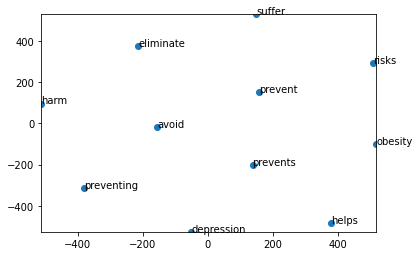

In [33]:
display_closestwords_tsnescatterplot(embedding.model, 'prevent')

In [28]:
embedding.model.similar_by_word('prevent')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('avoid', 0.8950472474098206),
 ('eliminate', 0.8921524882316589),
 ('helps', 0.8906171917915344),
 ('preventing', 0.8783411383628845),
 ('suffer', 0.8755894899368286),
 ('depression', 0.8702067136764526),
 ('prevents', 0.866199254989624),
 ('harm', 0.8641205430030823),
 ('risks', 0.8636987805366516),
 ('obesity', 0.8606697916984558)]